In [1]:
import os
import sys

In [2]:
sys.path.append('../lib')

In [3]:
import cov_independence_test
import gen_processes;


In [4]:
from importlib import reload
reload(cov_independence_test);
reload(gen_processes);

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.tsa.ar_model as ar
import torch
torch.set_default_dtype(torch.double)
import sigkernel

In [6]:
import scipy.stats as stats

In [7]:
from tqdm import tqdm

In [8]:
from itertools import product

In [9]:
import matplotlib.pyplot as plt

In [10]:
RNG = np.random.default_rng(1234)

In [11]:
N = 6000
M = 100

In [12]:
def gen_ar_processes(n, corr, a = 0.8):
    z = torch.tensor(RNG.multivariate_normal([0, 0] , [[1, corr], [corr, 1]], n))
    x = torch.zeros(2, n)
    x[:, 0] = z[0, :]
    a = 0.8
    for i, zi in enumerate(z[1:, :]):
        x[:, i+1] = a*x[:, i] + zi 
        
    return x

In [13]:
def gen_short_samples_burn_in(corr = 0):
    x_short_samples = torch.zeros(M, N, 2)
    for i in range(M):
        process = gen_ar_processes(10000+N, corr)
        x_short_samples[i, :, :] = process[:, 10000:].T
    return x_short_samples

In [14]:
samples = gen_short_samples_burn_in(0.2)

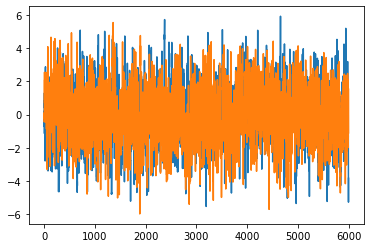

In [15]:
plt.plot(samples[0, :, 0])
plt.plot(samples[0, :, 1])

In [16]:
autocorr_est = torch.zeros(M, 200, 2)

for i in range(200):
    autocorr_est[:, i, :] = (samples[:, i:, :] * samples[:, :N-i, :]).mean(axis = 1)

In [17]:
n = np.array([float(i) for i in range(200)])
g_h = 0.8**n/(1-0.8**2)

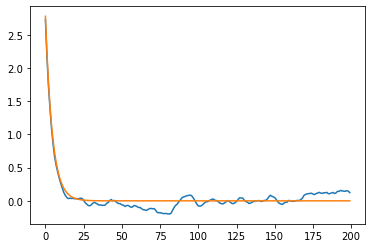

In [18]:
plt.plot(autocorr_est[0, :200, 0])
plt.plot(g_h[:200])

In [19]:
prod_autocorr_est = autocorr_est[:, :, 0] * autocorr_est[:, :, 1]

In [20]:
asymptotic_variance = (prod_autocorr_est.sum(axis = 1) + prod_autocorr_est[:, 1:].sum(axis = 1))/N
asymptotic_std = torch.sqrt(asymptotic_variance)

In [21]:
print(asymptotic_variance)

tensor([0.0054, 0.0071, 0.0067, 0.0066, 0.0055, 0.0067, 0.0055, 0.0060, 0.0054,
        0.0053, 0.0053, 0.0056, 0.0060, 0.0070, 0.0060, 0.0051, 0.0051, 0.0064,
        0.0074, 0.0064, 0.0055, 0.0064, 0.0058, 0.0057, 0.0062, 0.0057, 0.0062,
        0.0059, 0.0065, 0.0052, 0.0059, 0.0065, 0.0070, 0.0070, 0.0057, 0.0061,
        0.0055, 0.0054, 0.0064, 0.0060, 0.0060, 0.0053, 0.0055, 0.0068, 0.0053,
        0.0063, 0.0052, 0.0058, 0.0058, 0.0058, 0.0053, 0.0058, 0.0054, 0.0050,
        0.0054, 0.0062, 0.0061, 0.0062, 0.0055, 0.0057, 0.0064, 0.0057, 0.0062,
        0.0064, 0.0062, 0.0061, 0.0074, 0.0059, 0.0055, 0.0061, 0.0050, 0.0059,
        0.0064, 0.0058, 0.0056, 0.0060, 0.0058, 0.0070, 0.0058, 0.0060, 0.0048,
        0.0066, 0.0060, 0.0057, 0.0061, 0.0073, 0.0069, 0.0059, 0.0058, 0.0049,
        0.0057, 0.0068, 0.0058, 0.0073, 0.0058, 0.0055, 0.0058, 0.0060, 0.0057,
        0.0052])


In [22]:
c_est = torch.zeros(M, 200)

for i in range(200):
    c_est[:, i] = (samples[:, i:, 0] * samples[:, :N-i, 1]).mean(axis = 1)

In [23]:
(torch.abs(c_est).T > asymptotic_std*2).sum()/(100*200)

tensor(0.0754)

In [24]:
print(c_est[1, :].max())

tensor(0.5909)


In [25]:
scores = []
for i in range(M):
    scores.append(cov_independence_test.get_test_result(samples[i, :, 0], samples[i, :, 1])[1] > 0.05)

In [26]:
np.array(scores).sum()/len(scores)

0.99

In [27]:
print(cov_independence_test.get_test_result(samples[1, :, 0], samples[1, :, 1]))

(tensor(-0.0053), 0.5251216263445722)


In [28]:
print(np.sqrt(0.0072))

0.08485281374238571


In [29]:
print(asymptotic_std.mean())

tensor(0.0771)


In [30]:
null_dist = stats.norm(0, asymptotic_std.mean())
x = np.linspace(-1, 1, 100)
density = null_dist.pdf(x)

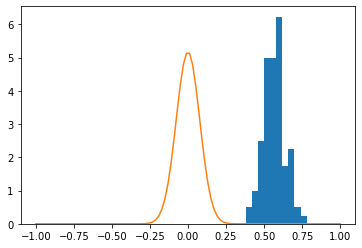

In [31]:
plt.hist([i.item() for i in c_est[:, 0]], density = True)
plt.plot(x, null_dist.pdf(x))

In [32]:
null_dist.cdf(0.25)

0.9994049795179051

In [33]:
c_est.max()

tensor(0.7797)

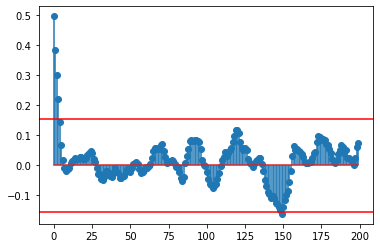

In [34]:
fig, ax = plt.subplots()
ax.stem(c_est[0, :])
ax.axhline(asymptotic_std.mean()*2, color = 'red')
ax.axhline(-asymptotic_std.mean()*2, color = 'red')